# Neural induction though covalent modification cycle and mapk cascade. 
# A switch or not a switch? 

http://www.pnas.org/content/93/19/10078.long

## Packages and formating

Import packages

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from matplotlib import rc


commands and definitions for nice latex rendering - nothing bio/physical

In [2]:
#for latex-rendering. (I guess with a lot of redundancy.. but it works!)
rc('text', usetex=True) #
plt.rcParams['text.usetex'] = True #this line turns "ticks" on axis into latex  (i think is it the same function as the line above. not sure. )
plt.rcParams['text.latex.unicode'] = True 
#for the size of the exported figures
plt.rcParams['figure.figsize'] = (24, 18)
rc('text.latex', preamble=r'\usepackage{cmbright}')#this line turns text in legends for instance into latex


def round_to_n(x, n):
    " Round x to n significant figures "
    return round(x, -int(math.floor(np.sign(x) * math.log10(abs(x)))) + n)

def str_fmt(x, n=2):
    " Format x into nice Latex rounding to n"
    if x<0.1:
        if x!=.01 and x!=.001 and x!=.0001 and x!=.00001:
            power = int(np.log10(round_to_n(x, 0)))-1
            mypower=int(math.floor(np.sign(x) * math.log10(abs(x))))
            f_SF = round_to_n(x, n) * pow(10, -power)
            f_SF = math.floor(x*10**(-mypower+2))/100
            return r"${} \, 10^{{ {} }}$".format(f_SF, mypower)
        else:
            power = int(np.log10(round_to_n(x, 0)))
            f_SF = round_to_n(x, n) * pow(10, -power)
            return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    else:
        return r"${}$".format(x)
    
def str_fmt_round_numb(x, n=1):
    " Format x into nice Latex rounding to n"
    if x<0.1:
        power = int(np.log10(round_to_n(x, 0)))-1
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"${} \, 10^{{ {} }}$".format(f_SF, power)
    else:
        return r"${}$".format(x)

def str_fmt_name_fig(x, n=2):
    " Format x into nice text - rounding to n"
    if x<0.1:
        if x!=.01 and x!=.001 and x!=.0001 and x!=.00001:
            power = int(np.log10(round_to_n(x, 0)))-1
            mypower=int(math.floor(np.sign(x) * math.log10(abs(x))))
            f_SF = round_to_n(x, n) * pow(10, -power)
            f_SF = math.floor(x*10**(-mypower+2))/100
            return r"{}*10({})".format(f_SF, mypower)
        else:
            power = int(np.log10(round_to_n(x, 0)))
            f_SF = round_to_n(x, n) * pow(10, -power)
            return r"{}*10^({ })".format(f_SF, power)
    elif x>99:
        power = int(np.log10(round_to_n(x, 0)))
        f_SF = round_to_n(x, n) * pow(10, -power)
        return r"{}*10^({ })".format(f_SF, power)
    else:
        return r"{}$".format(x)
    


## Endode equations of the model and a set default parameters

Choose values for parameters

In [3]:


scale = 1  #to be able to change units if needed


tmax = 30        #solve the system of ODEs from t=0 to tmax (about 30 min for the cell to divide)
tmaxLONG = 1000  #what would be the steady state? (look at longer times)
 


WTV = 0.0023*scale  #not used in the code - small to have a small input in the cascade, cf Ferrell.. *)
rasgapV = .0002*scale # not used 
sostotV=1*scale

k11V = 1 #(* randomly chosen *)
k12V = 1

d11V = 1 #(* randomly chosen *)
d12V = 1 #(* randomly chosen *)
a11V = 10000/scale #(* randomly chosen *)
a12V = 10000/scale #(* randomly chosen *)
nn = 10

mapKKKtot = .003*scale
mapKKtot = 1.2*scale #(*1.2*)
mapKtot=1.2*scale
mapKKpase = .0003*scale
mapKpase = .12*scale
e2totV = 0.0003*scale




rasgtp_inputV=1*scale



kdissC=150

v1V=kdissC
v2V=kdissC
v3V=kdissC
v4V=kdissC
v5V=kdissC
v6V=kdissC
v7V=kdissC
v8V=kdissC
v9V=kdissC
v10V=kdissC


KM=300/1000
k1V=KM
k2V=KM
k3V=KM
k4V=KM
k5V=KM
k6V=KM
k7V=KM
k8V=KM 
k9V=KM
k10V=KM


Encode equations of the model

In [4]:
var_names = 'rasgdp', 'WE1', 'WsE2', 'mapKKK', 'mapKK', 'mapKKstar', 'mapK', 'mapKstar'
            

params_names = 'WT', 'a11', 'a12', 'd11', 'd12', 'k11', 'k12',\
              'rasgap', 'sostot', 'e2tot','mapKKKtot', 'mapKKtot', 'mapKtot', 'mapKKpase', 'mapKpase' ,\
              'v1','v2','v3','v4','v5','v6','v7','v8','v9','v10',\
            'k1','k2','k3','k4','k5','k6','k7','k8','k9','k10'

def equationsfullmodel(var, t, params):
    
    rasgdp, WE1, WsE2, mapKKK, mapKK, mapKKstar, mapK, mapKstar = var
    
    WT, a11, a12, d11, d12, k11, k12, rasgap, sostot, \
    e2tot, mapKKKtot, mapKKtot, mapKtot, mapKKpase, mapKpase, \
    v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, \
    k1, k2, k3, k4, k5, k6, k7, k8, k9, k10 = params
    
    rasgtp=WT - rasgdp - WE1 - WsE2
    
    drasgdp = -a11*rasgdp*(sostot - WE1) + d11*WE1 + k12*WsE2
    dWE1 = a11*rasgdp*(sostot - WE1) - (d11 + k11)*WE1
    dWsE2 = a12*rasgtp*(rasgap - WsE2) - (d12+k12)*WsE2
    
    #dmos = - a mos*e1 + d1 mos-e1 + k2 mos*-e2 !!! bizarre d'ecrire une reaction pour mos alors qu'on utilise sa conservation ...
    
    mapKKKstar=mapKKKtot-mapKKK
    mapKKstar2=mapKKtot-mapKK-mapKKstar
    mapKstar2=mapKtot-mapK-mapKstar
    
    Vmax= v1*(WT - rasgdp - WE1 - WsE2)
    Vmax2=v2*e2tot
    Vmax3=v3*mapKKKstar
    Vmax4=v4*mapKKpase
    Vmax5=Vmax3
    Vmax6=Vmax4
    Vmax7=v7*mapKKstar2
    Vmax8=v8*mapKpase
    Vmax9=Vmax7
    Vmax10=Vmax8
    
    
    dmapKKK = - Vmax*mapKKK/(k1 + mapKKK) + Vmax2*mapKKKstar/(k2+mapKKKstar)
    dmapKK = -Vmax3*mapKK/(k3+mapKK)+Vmax4*mapKKstar/(k4+mapKKstar)
    dmapKKstar = - Vmax4*mapKKstar/(k4+mapKKstar) + Vmax5*mapKKstar2/(k5+mapKKstar2)
    dmapK = -Vmax7*mapK/(k7+mapK)+Vmax8*mapKstar/(k8+mapKstar)
    dmapKstar = - Vmax9*mapKstar/(k9+mapKstar)+Vmax10*mapKstar2/(k10+mapKstar2)
     
    return [drasgdp, dWE1, dWsE2, dmapKKK,dmapKK,dmapKKstar,dmapK,dmapKstar]


In [5]:
param_v  = [WTV, a11V, a12V, d11V, d12V, k11V, k12V, rasgapV, sostotV, \
            e2totV, mapKKKtot, mapKKtot, mapKtot, mapKKpase, mapKpase,\
    v1V, v2V, v3V, v4V, v5V, v6V, v7V, v8V, v9V, v10V, \
    k1V, k2V, k3V, k4V, k5V, k6V, k7V, k8V, k9V, k10V]


In [6]:
for kk in range(len(params_names)):
    print(kk, params_names[kk],param_v[kk] )
    

0 WT 0.0023
1 a11 10000.0
2 a12 10000.0
3 d11 1
4 d12 1
5 k11 1
6 k12 1
7 rasgap 0.0002
8 sostot 1
9 e2tot 0.0003
10 mapKKKtot 0.003
11 mapKKtot 1.2
12 mapKtot 1.2
13 mapKKpase 0.0003
14 mapKpase 0.12
15 v1 150
16 v2 150
17 v3 150
18 v4 150
19 v5 150
20 v6 150
21 v7 150
22 v8 150
23 v9 150
24 v10 150
25 k1 0.3
26 k2 0.3
27 k3 0.3
28 k4 0.3
29 k5 0.3
30 k6 0.3
31 k7 0.3
32 k8 0.3
33 k9 0.3
34 k10 0.3


## Initial conditions : what is the state of the system at the begining of the 32-cell stage?

We assume that the different elements of the signalling pathway are all 'unactivated'.

In [7]:
###################################
# INITIAL CONDTIONS
###################################

initialcond = np.zeros(len(var_names))
initialcond[0]=param_v[0]
initialcond[3] = mapKKKtot
initialcond[4] = mapKKtot
initialcond[6] = mapKtot
###################################
# time array & array to store the output for various input levels of sos
###################################

tStop = tmaxLONG
tInc = 0.001
t = np.arange(0., tStop, tInc)

print("The initial conditions are {}(0) = {}, {}(0) = {}, {}(0)= {} and {}(0) = {}".format(var_names[0],params_names[0], \
                                                                                var_names[3],mapKKKtot, \
                                                                 var_names[4],'mapkktot', \
                                                                 var_names[6],'mapktot'))

The initial conditions are rasgdp(0) = WT, mapKKK(0) = 0.003, mapKK(0)= mapkktot and mapK(0) = mapktot


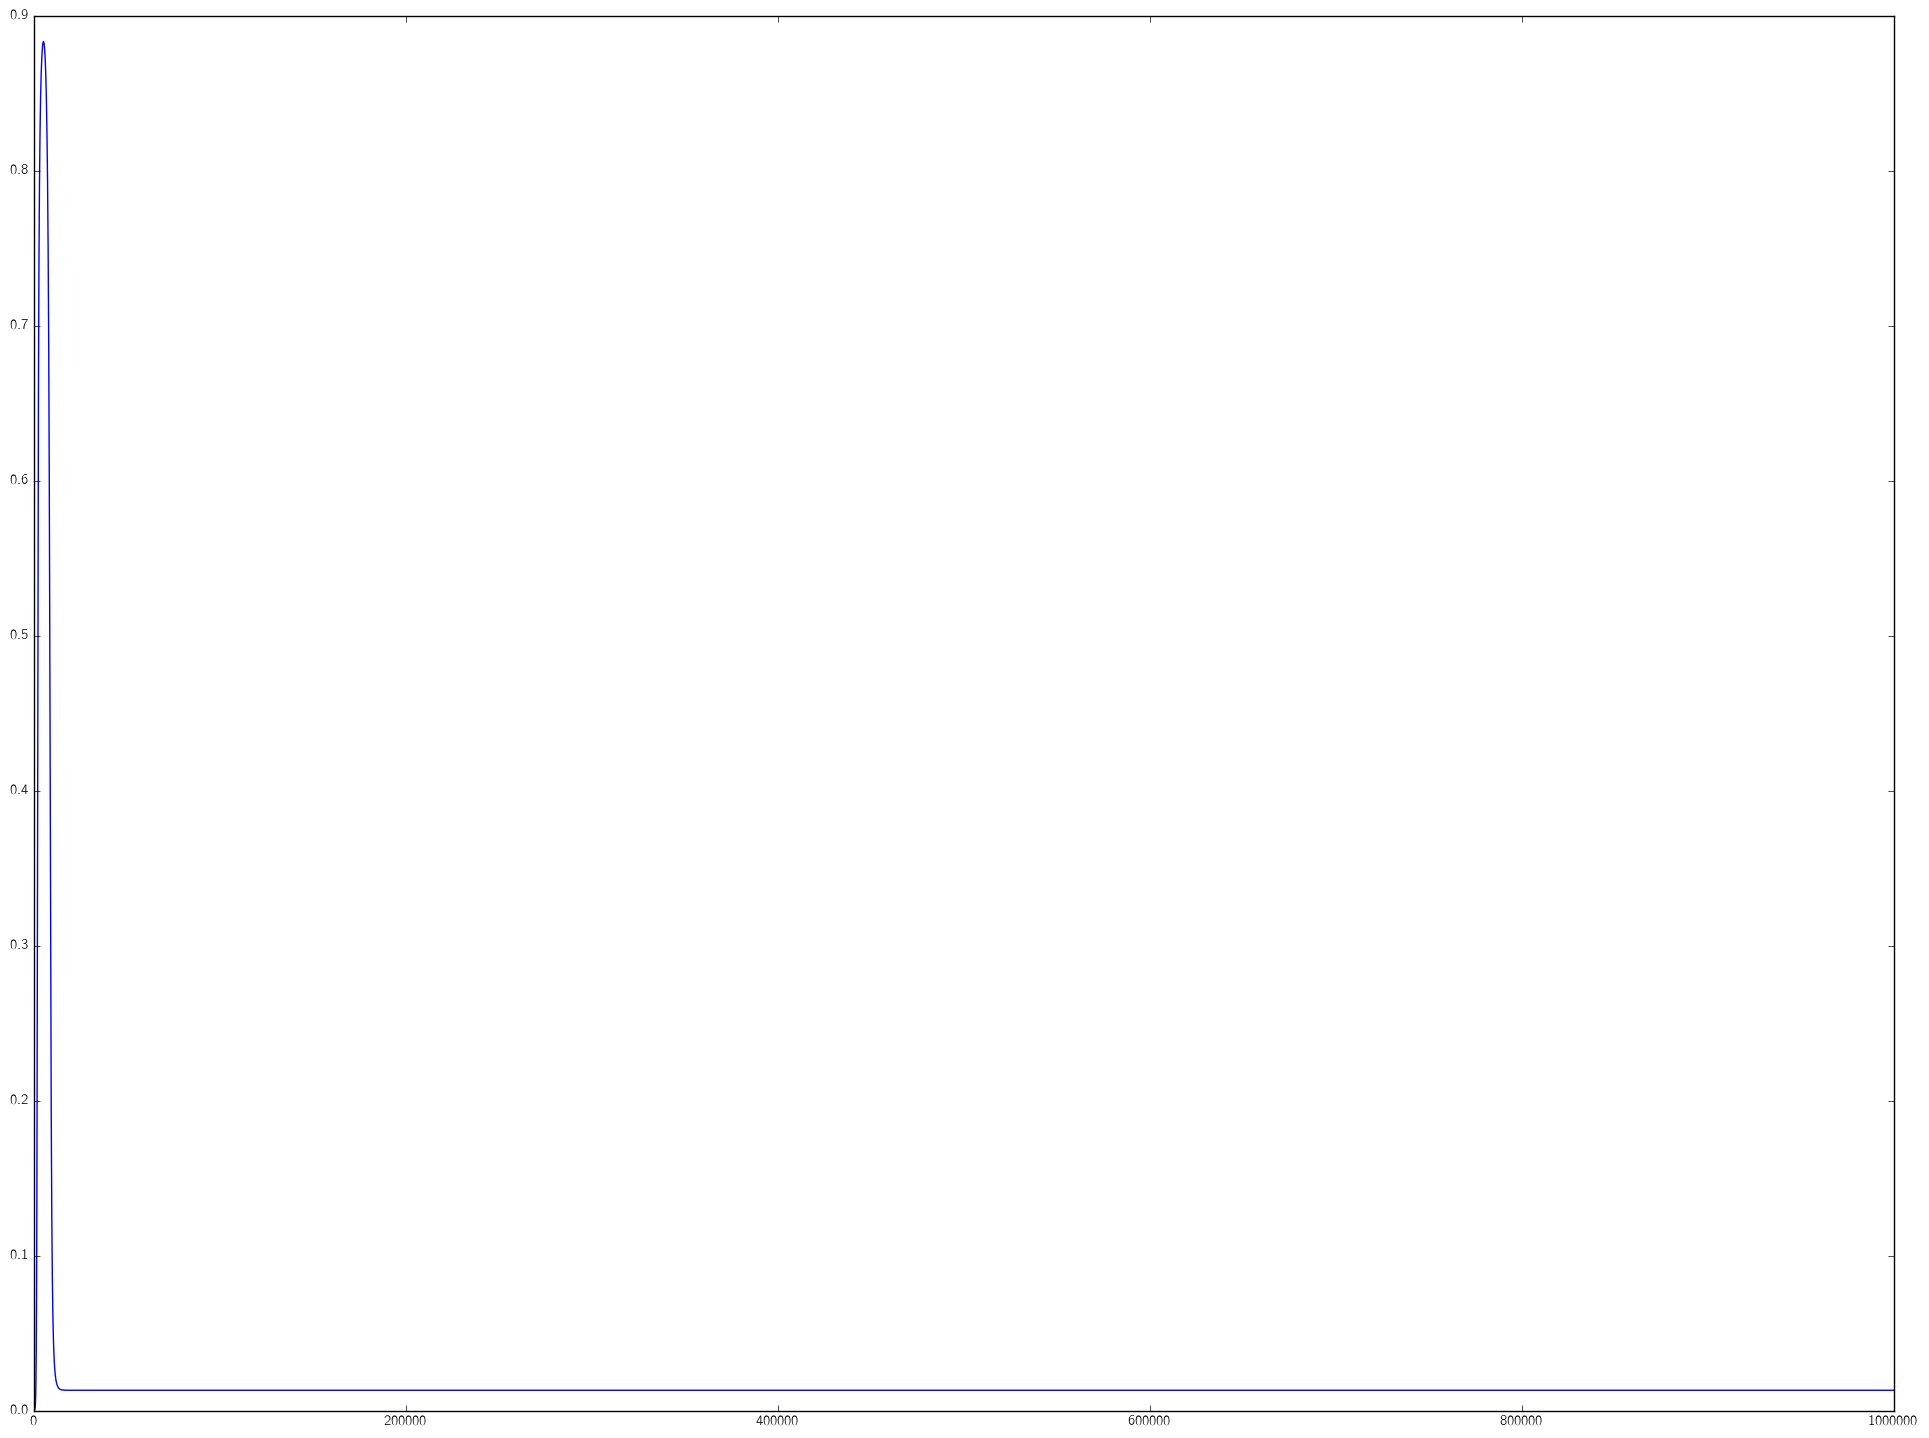

In [8]:
psoln = odeint(equationsfullmodel, initialcond, t, args=(param_v,))

plt.plot((param_v[12]*np.ones(len(t))-psoln[:,6]-psoln[:,7])/param_v[12],label=r"$ \textnormal{mapk \star \star}$")

plt.show()

## Warming-up : Loop over one input, solve equations, and store value reached by the output 

We have a system with one input (the concentration of rasdtp which is not directly a parameter of our model, it is computed from the value of rasgdp...). We take $maxn$ different input values and plot only 5 solutions. 

In [9]:
# Input of the pathway: FGF signaling via SOS : 
maxn = 100; #number of points 
sostotlist=np.logspace(-8, 2, num=4)#np.geomspace(10**(-8), WTV, num=maxn)*scale #logarithmic ploting
maxn=len(sostotlist)
maxplots=5;
#selectedinput=range(1,maxn,divmod(maxn,maxplots)[0])#we plot only n=maxplots plots 


maxn = 10
input1_list=np.logspace(-12, 1, num=maxn)*scale#np.logspace(10**(-8),WTV,num=maxn)
input2_list=np.logspace(-12, 1, num=maxn)*scale
maxplots=5;
selectedinput=range(1,maxn,divmod(maxn,maxplots)[0])#we plot only n=maxplots plots 

inputindex= 8
outputvariableindex =  6
input2index=7
maxoutputindex=12

print(r'The input parameter is {} and therefore the input index is {}'.format(params_names[inputindex],inputindex))
print(r'The ephrin input is {}, corresponding to parameter number {}'.format(params_names[input2index],input2index))

print(r'The output variable is {}, which is the {} th variable'.format(var_names[outputvariableindex],outputvariableindex))
print(r'The maximal value of the output is {}, corresponding to parameter number {}'.format(params_names[maxoutputindex],maxoutputindex))




storeoutput=[]

The input parameter is sostot and therefore the input index is 8
The ephrin input is rasgap, corresponding to parameter number 7
The output variable is mapK, which is the 6 th variable
The maximal value of the output is mapKtot, corresponding to parameter number 12


In [11]:
###################################
# ZOO CONDITIONS?
###################################

print(input1_list[maxn-1]/WTV<10**(-1))
print(rasgapV/WTV<10**(-1))
print((k11V+d11V)/a11V/WTV<10**(-1))
print((k12V+d12V)/a12V/WTV<10**(-1))


False
True
True
True


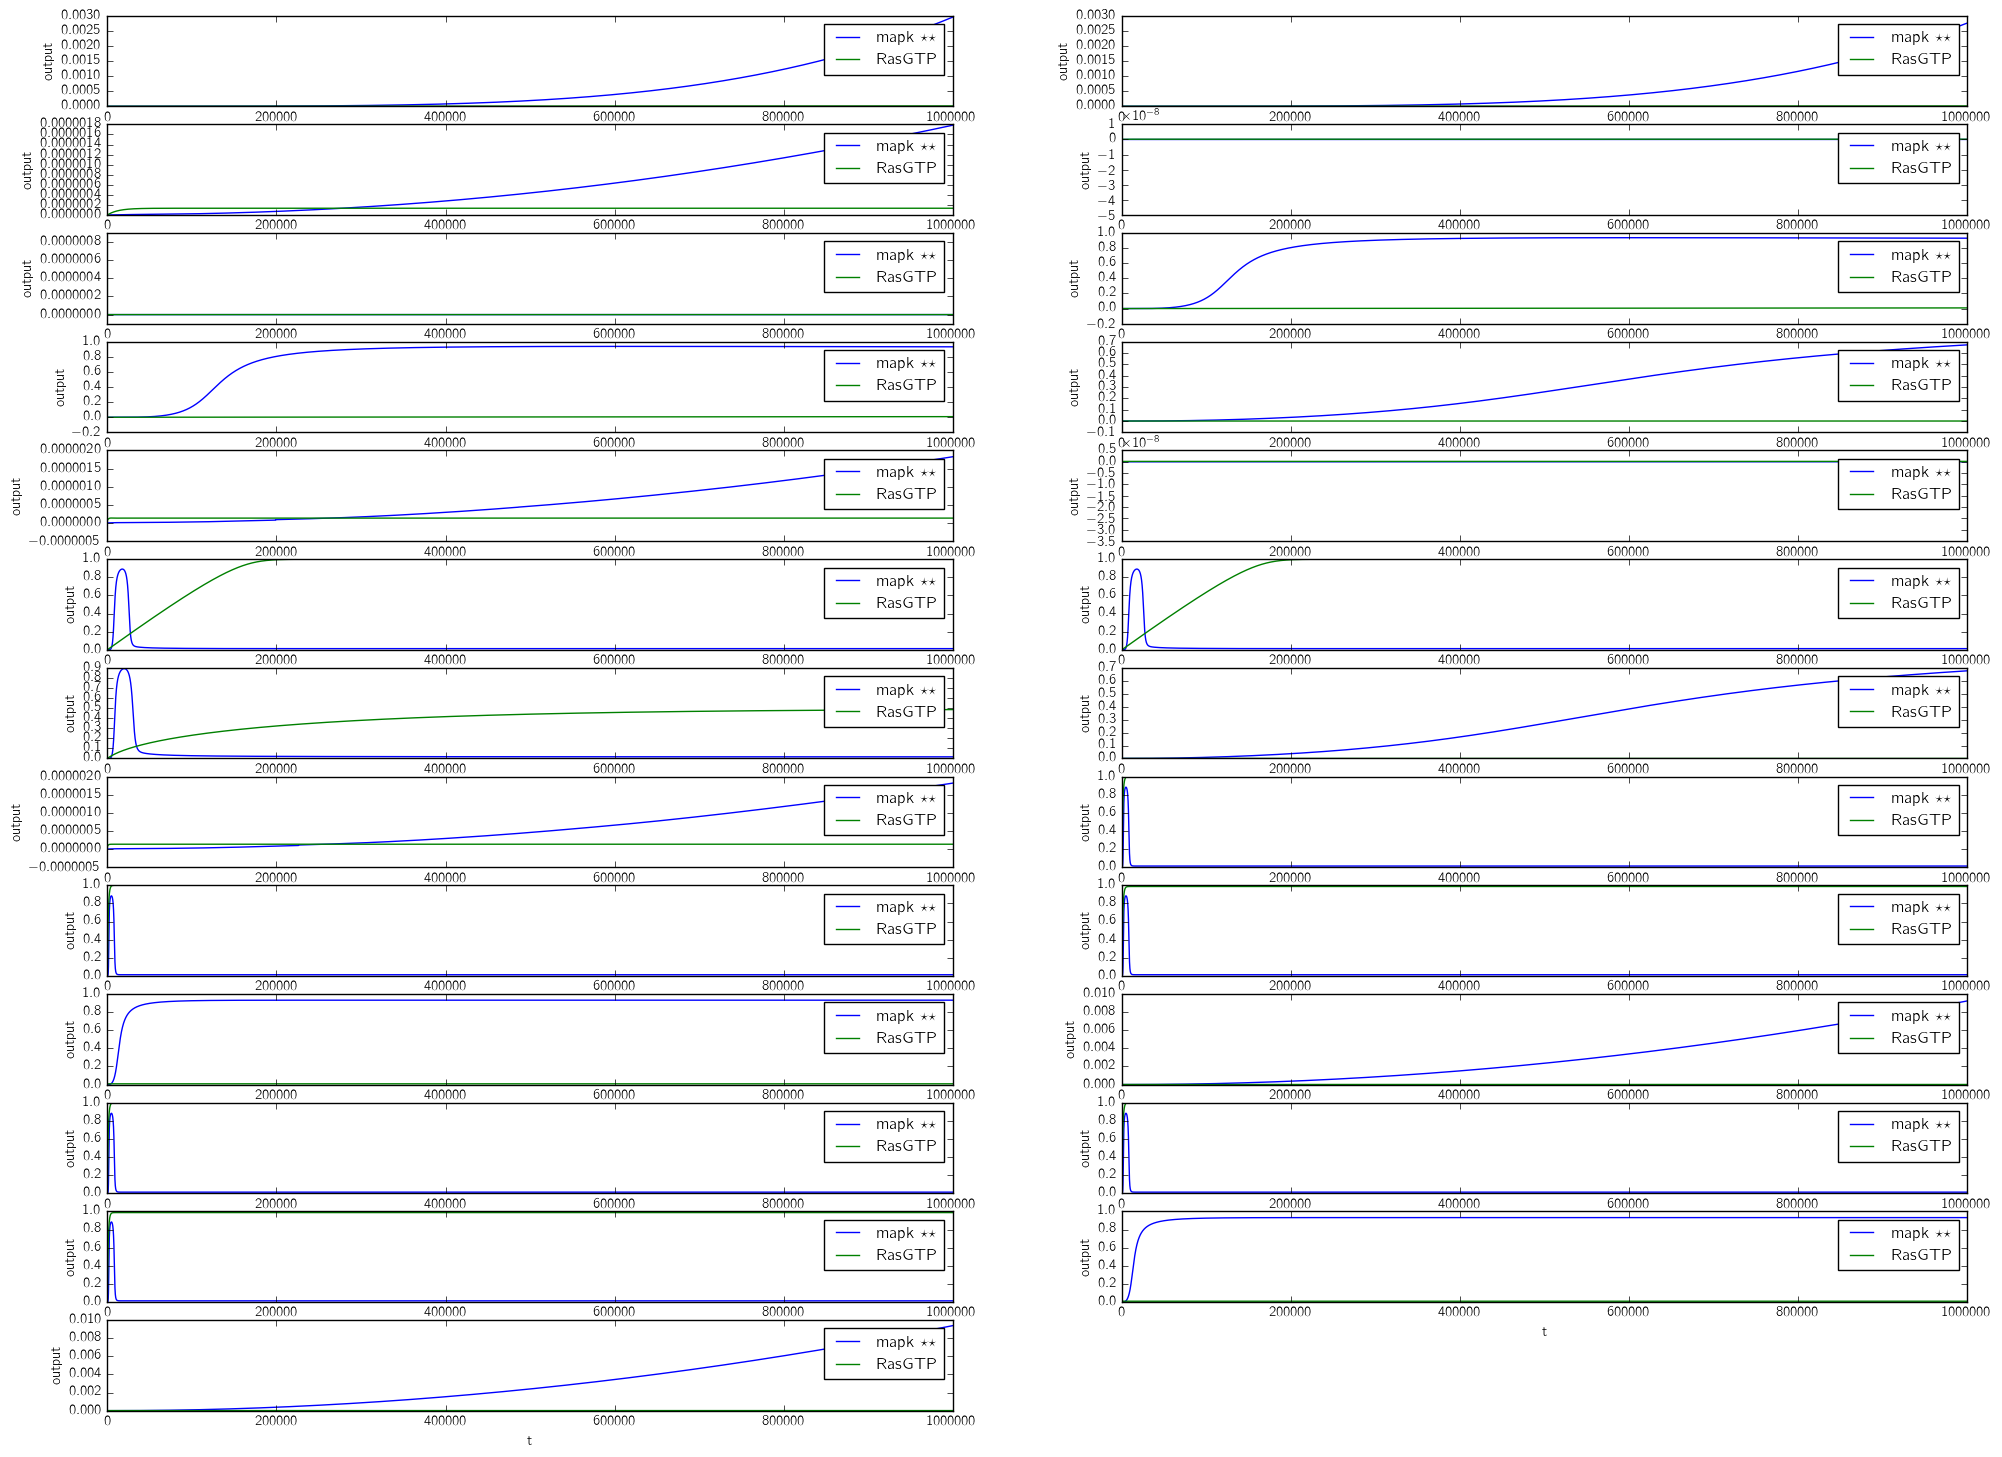

In [12]:
#to number plots    np.arange(1,math.floor(len(range(0,maxn,divmod(maxn,10)[0])))+1)

fig=plt.figure()
plotnumber=0
output=np.zeros((len(input1_list),len(input2_list)))
outputrasgdp=np.zeros((len(input1_list),len(input2_list)))
for kk in range(len(input1_list)):
    for ll in range(len(input2_list)):

        #value of input:
        param_v[inputindex]=input1_list[kk]
        param_v[input2index]=input2_list[ll]
        #actually solving the equations:
        psoln = odeint(equationsfullmodel, initialcond, t, args=(param_v,))
        output[kk,ll]=param_v[maxoutputindex]-psoln[len(t)-1,6]-psoln[len(t)-1,7]
        outputrasgdp[kk,ll]=param_v[0] - psoln[len(t)-1,0] - psoln[len(t)-1,1]  - psoln[len(t)-1,2] 
        
        #to plot
        if kk in selectedinput:
            
            if ll in selectedinput:

                plotnumber=plotnumber+1
                plt.subplot(math.floor((len(selectedinput)**2+1)/2),2,plotnumber)
                #plot mapk star star
                plt.plot((param_v[maxoutputindex]*np.ones(len(t))-psoln[:,6]-psoln[:,7])/param_v[maxoutputindex],label=r"$ \textnormal{mapk \star \star}$")
                #plot max value of mapk star star
                #plt.plot(np.ones(len(t))*param_v[maxoutputindex],label=r" \textnormal{Mapk max}")
                #plot rasgdp
                plt.plot((np.ones(len(t))*param_v[0] - psoln[:,0] - psoln[:,1]  - psoln[:,2])/param_v[0], label=r"\textnormal{RasGTP}")
                #plt.plot(np.ones(len(t)),label=r" \textnormal{WT}")

                plt.legend()
                #plt.title(r'Temporal evolution of Mapk $\star \star$ for fgf input value = {} and erk input value = {}'.format(str_fmt(param_v[inputindex],n=2),str_fmt(param_v[input2index],n=2)))
                #plt.yticks([0, param_v[maxoutputindex]/4, param_v[maxoutputindex]/2, 3*param_v[maxoutputindex]/4, param_v[maxoutputindex]],
                #['$0$', r'{}'.format(str_fmt(param_v[maxoutputindex]/4)), r'{}'.format(str_fmt(param_v[maxoutputindex]/2)),r'{}'.format(str_fmt_round_numb(round_to_n(3*param_v[maxoutputindex]/4,2))), r'{}'.format(str_fmt(param_v[maxoutputindex]))])
                plt.ylabel('output')
                plt.xlabel('t')
     

"""hillc=hillcoef(inputlist,output,equationsfullmodel,initialcond, t,param_v,index_param_input=inputindex,index_output=outputindex,numberpoints=100)
ax=plt.subplot(math.floor(len(selectedinput)/2)+1,2,plotnumber+1)
ax.set_xscale('log')
ax.plot(inputlist,output)
plt.text(0.0001,0.05,r'Hill coefficient = {}'.format(round_to_n(hillc,2)), style='italic',bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10})
plt.ylabel('output at t=tmax')
plt.xlabel('Fgf input')

plt.show()

"""
plt.show()

In [38]:
(param_v[0] + psoln[len(t)-1,0] + psoln[len(t)-1,1]  + psoln[len(t)-1,2])/param_v[0]
psoln[len(t)-1,2]

0.0011499769978148451

In [159]:
print(var_names[0],psoln[:,0])
print(var_names[1],psoln[:,1])
print(var_names[2],psoln[:,2])
print(psoln[:,0]+psoln[:,1]+psoln[:,2])
print('inital gtp',WTV-(psoln[0,0]+psoln[0,1]+psoln[0,2]))
print('final gtp',WTV-(psoln[-1,0]+psoln[-1,1]+psoln[-1,2]))
psoln[-1,outputindex]

rasgdp [  2.30000000e-03   2.30047623e-08   2.30047920e-08 ...,   2.30021852e-08
   2.30021852e-08   2.30021852e-08]
WE1 [ 0.          0.0022977   0.00229542 ...,  0.00114998  0.00114998
  0.00114998]
WsE2 [  0.00000000e+00   2.24984541e-06   4.53703480e-06 ...,   1.14997700e-03
   1.14997700e-03   1.14997700e-03]
[ 0.0023      0.00229998  0.00229998 ...,  0.00229998  0.00229998
  0.00229998]
inital gtp 0.0
final gtp 2.30021851549e-08


IndexError: index 18 is out of bounds for axis 1 with size 8

## Our purpose 1 : compute Hill coefficients as a function of input 2 

In [62]:

# ERK/rasgap Input of the pathway
maxn2 = 10; #number of points 
input2list=np.logspace(-8, 0, num=maxn2)*scale #logarithmic ploting


#initiate list to store hill coefficient (as a function of input2(rasgap))
listhill=np.zeros(len(input2list))

for jj in range(len(input2list)):
    
    print(jj)
    param_v[input2index]=input2list[jj]

    fig=plt.figure()
    plotnumber=0
    output=np.zeros(len(inputlist))

    for kk in range(len(inputlist)):
        #value of input:
        param_v[inputindex]=inputlist[kk]
        #actually solving the equations:
        psoln = odeint(equationsfullmodel, initialcond, t, args=(param_v,))
        output[kk]=psoln[len(t)-1,outputindex]
        if kk in selectedinput:

            plotnumber=plotnumber+1
            plt.subplot(math.floor(len(selectedinput)/2)+1,2,plotnumber)
            plt.plot(psoln[:,outputindex],label=r"$ \textnormal{mapk \star \star}$")
            #plot max value of mapk star star
            plt.plot(np.ones(len(t))*param_v[4],label=r" \textnormal{Mapk max}")
            plt.legend()
            plt.title(r'Temporal evolution of Mapk $\star \star$ for fgf input value = {} and erk input value = {}'.format(str_fmt(param_v[inputindex],n=2),str_fmt(param_v[input2index],n=2)))
            plt.yticks([0, param_v[maxoutputindex]/4, param_v[maxoutputindex]/2, 3*param_v[maxoutputindex]/4, param_v[maxoutputindex]],
            ['$0$', r'{}'.format(str_fmt(param_v[maxoutputindex]/4)), r'{}'.format(str_fmt(param_v[maxoutputindex]/2)),r'{}'.format(str_fmt_round_numb(round_to_n(3*param_v[maxoutputindex]/4,2))), r'{}'.format(str_fmt(param_v[maxoutputindex]))])
            plt.ylabel('output')
            plt.xlabel('t')

    hillc=hillcoef(inputlist,output,equationsfullmodel,initialcond, t,param_v,index_param_input=inputindex,index_output=outputindex,numberpoints=100)
    listhill[jj]=hillc
    ax=plt.subplot(math.floor(len(selectedinput)/2)+1,2,plotnumber+1)
    ax.set_xscale('log')
    ax.plot(inputlist,output)
    plt.text(0.0001,0.05,r'Hill coefficient = {}'.format(round_to_n(hillc,2)), style='italic',bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10})
    plt.ylabel('output at t=tmax')
    plt.xlabel('Fgf input')

    fig.savefig(r'time_traces_erk_{}.pdf'.format(str_fmt_name_fig(param_v[input2index])))      
    plt.close(fig)


0
1
2
3
4
5
6
7
8
9


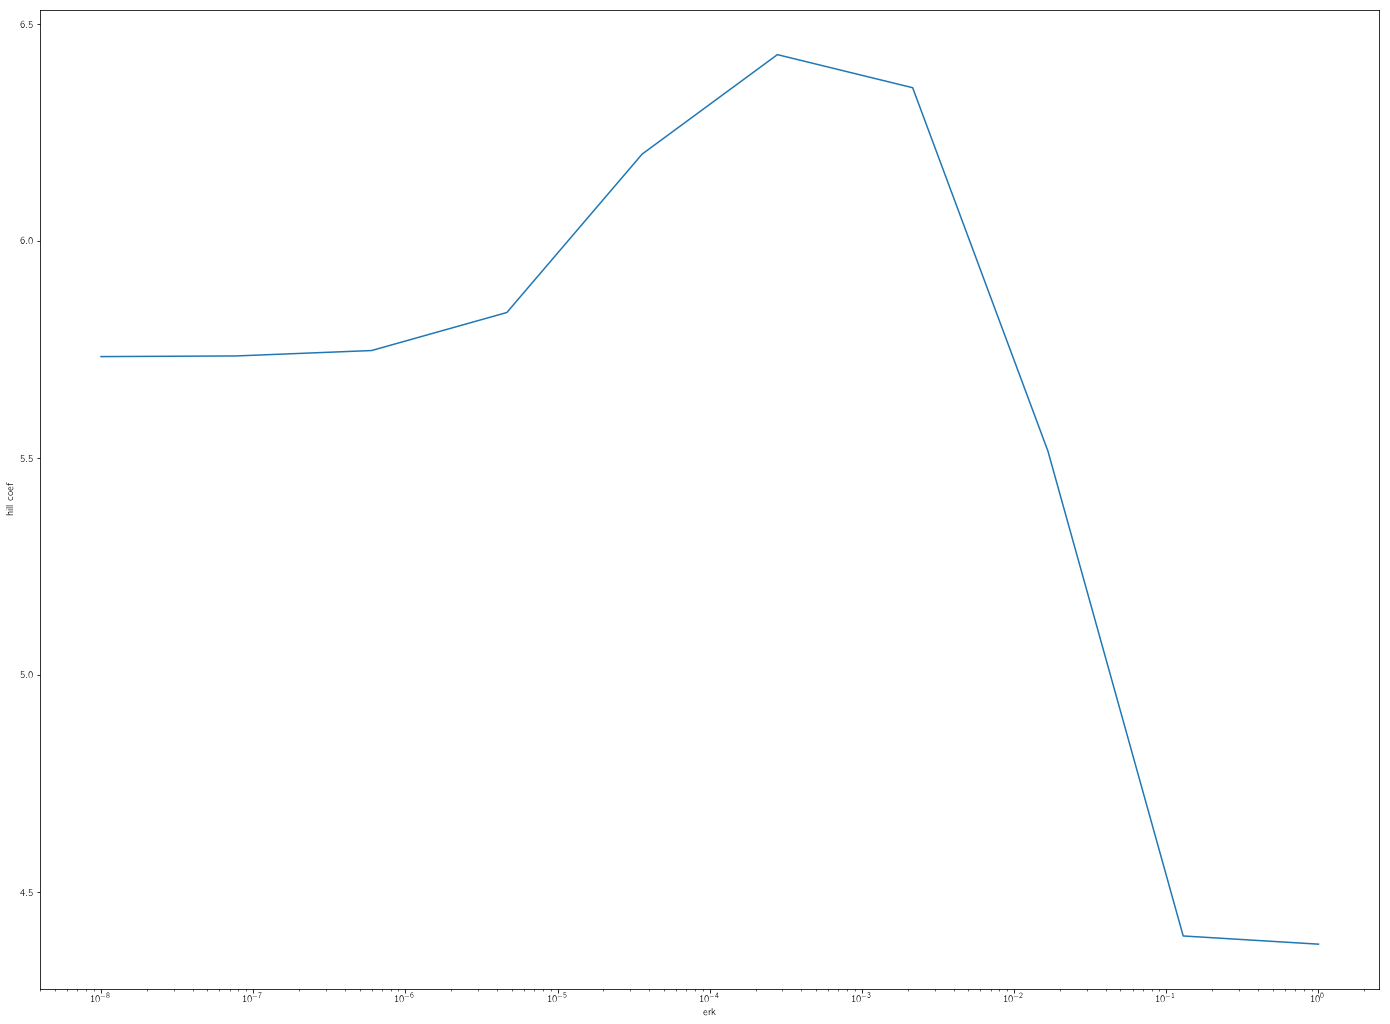

In [65]:
plt.close(fig)

fig=plt.figure()
plt.plot(input2list,listhill,label=r"hill coef/input2")#,label="computed points"
#plt.legend(loc=4)
#plt.yticks([0, ymaxtick/4, ymaxtick/2, 3*ymaxtick/4, ymaxtick],
#          ['$0$', r'{}'.format(str_fmt(ymaxtick/4)), r'{}'.format(str_fmt(ymaxtick/2)), r'{}'.format(str_fmt(3*ymaxtick/4)), r'{}'.format(str_fmt(ymaxtick))])
plt.ylabel('hill coef')
plt.xlabel('erk')
plt.xscale('log')
#plt.text(10,ymaxtick/4,r'Hill coef = {}'.format(hillcoef)))
# !!! if you did an extrapolation and want to plot it add next 2 lines!!!!
#plt.plot(selectedsos,f(selectedsos),label="extrapolation")
#plt.legend()

#fig.savefig(r'hillcoef_erk.pdf')      
plt.show()

## Our purpose 2 : compute Hill coefficients as a function of input 2 - explore parameter space

In [66]:
param_v=np.rand

[0.0023,
 10000.0,
 10000.0,
 1,
 1,
 1,
 1,
 1.0,
 0.00096076188774790749,
 0.003,
 0.0003,
 1.2,
 0.0003,
 1.2,
 0.12,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 150,
 3.7539218229773175e-05,
 150,
 150,
 150,
 150]

In [ ]:
number_of_parameter_sets=10


# ERK/rasgap Input of the pathway
maxn2 = 10; #number of points 
input2list=np.logspace(-8, 0, num=maxn2)*scale #logarithmic ploting
maxplot2=5
selectedinput2=range(1,maxn2,divmod(maxn,maxplots2)[0])

#initiate list to store hill coefficient (as a function of input2(rasgap))
listhill=np.zeros(len(input2list))

for jj in range(len(input2list)):
    
    print(jj)
    param_v[input2index]=input2list[jj]

    fig=plt.figure()
    plotnumber=0
    output=np.zeros(len(inputlist))

    for kk in range(len(inputlist)):
        #value of input:
        param_v[inputindex]=inputlist[kk]
        #actually solving the equations:
        psoln = odeint(equationsfullmodel, initialcond, t, args=(param_v,))
        output[kk]=psoln[len(t)-1,outputindex]
        if (kk in selectedinput) and (jj in selectedinput2):

            plotnumber=plotnumber+1
            plt.subplot(math.floor(len(selectedinput)/2)+1,2,plotnumber)
            plt.plot(psoln[:,outputindex],label=r"$ \textnormal{mapk \star \star}$")
            #plot max value of mapk star star
            plt.plot(np.ones(len(t))*param_v[4],label=r" \textnormal{Mapk max}")
            plt.legend()
            plt.title(r'Temporal evolution of Mapk $\star \star$ for fgf input value = {} and erk input value = {}'.format(str_fmt(param_v[inputindex],n=2),str_fmt(param_v[input2index],n=2)))
            plt.yticks([0, param_v[maxoutputindex]/4, param_v[maxoutputindex]/2, 3*param_v[maxoutputindex]/4, param_v[maxoutputindex]],
            ['$0$', r'{}'.format(str_fmt(param_v[maxoutputindex]/4)), r'{}'.format(str_fmt(param_v[maxoutputindex]/2)),r'{}'.format(str_fmt_round_numb(round_to_n(3*param_v[maxoutputindex]/4,2))), r'{}'.format(str_fmt(param_v[maxoutputindex]))])
            plt.ylabel('output')
            plt.xlabel('t')

    hillc=hillcoef(inputlist,output,equationsfullmodel,initialcond, t,param_v,index_param_input=inputindex,index_output=outputindex,numberpoints=100)
    listhill[jj]=hillc
    ax=plt.subplot(math.floor(len(selectedinput)/2)+1,2,plotnumber+1)
    ax.set_xscale('log')
    ax.plot(inputlist,output)
    plt.text(0.0001,0.05,r'Hill coefficient = {}'.format(round_to_n(hillc,2)), style='italic',bbox={'facecolor':'lightblue', 'alpha':0.5, 'pad':10})
    plt.ylabel('output at t=tmax')
    plt.xlabel('Fgf input')

    fig.savefig(r'time_traces_erk_{}.pdf'.format(str_fmt_name_fig(param_v[input2index])))      
    plt.close(fig)

## Define a function to compute Hill coefficients accurately 

In [48]:
def hillcoef(input,output,equationsmodel,initialcond, t,param_v,index_param_input=40,index_output=15,numberpoints=100):
    "This function compute the Hill coefficient for a given a rough input/output set of points" 
    "It needs the ODEs that give the output given the input, the initial cnoditon, a time vector to solve ODEs"
    "The parameters involved in the ODEs and the index of the parameter that correspond to changing the input"
    "numberpoints: specify how many points we add localy to find the inputs giving .1 and .9 of the maxoutput"
    maxoutput=max(output)
    #
    approxloc09=np.abs(output-.9*maxoutput).argmin()#position in the array of approximate location
    if approxloc09+2<len(input):
        input09=np.linspace(input[approxloc09-2],input[approxloc09+2],numberpoints)#generate more output points near that approximate location 
    else:
        input09=np.linspace(input[approxloc09-2],input[approxloc09+1],numberpoints)
    output09=[-1]#initiate the local output array
    #
    #
    for i in range(0,len(input09)):
        param_v[index_param_input]=input09[i
        psoln = odeint(equationsmodel, initialcond, t, args=(param_v,))
        outputtostore=psoln[len(t)-1,index_output]
        output09=np.append(output09,[outputtostore])
    # 
    output09=output09[1:]
    inversef=interp1d(output09,input09)
    loc09=inversef(.9*maxoutput)
    #
    #
    approxloc01=np.abs(output-.1*maxoutput).argmin()#position in the array of approximate location
    input01=np.linspace(input[approxloc01-2],input[approxloc01+2],numberpoints)#generate more output points near that approximate location 
    output01=[-1]
    #
    #
    for i in range(0,len(input01)):
        param_v[index_param_input]=input01[i]
        psoln = odeint(equationsmodel, initialcond, t, args=(param_v,))
        outputtostore=psoln[len(t)-1,index_output]
        output01=np.append(output01,[outputtostore])
    # 
    output01=output01[1:]
    inversef=interp1d(output01,input01)
    loc01=inversef(.1*maxoutput)
    #
    return math.log(81)/math.log(loc09/loc01)
    
